In [ ]:
# =============================================================================
# MYTHRA GLYPHNET - Unified Glyph Generation System
# =============================================================================

import os
import requests
import replicate
import yaml
from dotenv import load_dotenv
from IPython.display import display, Image, HTML
from datetime import datetime
from pathlib import Path

# Load environment variables from .env file
load_dotenv()

# Get API token from environment
api_token = os.getenv("REPLICATE_API_TOKEN")
if api_token:
    os.environ["REPLICATE_API_TOKEN"] = api_token
    print(f"✅ API token loaded from .env (ends with: ...{api_token[-8:]})")
else:
    print("❌ REPLICATE_API_TOKEN not found in .env file")
    print("💡 Please add your token to .env file: REPLICATE_API_TOKEN=your_token_here")

# Create organized output directories
output_dirs = [
    "results/glyphs/generic",    # gGlyphs - universal symbols
    "results/glyphs/dream",      # dGlyphs - amalgamated symbols  
    "results/glyphs/sumi",       # SUMI style glyphs
    "results/glyphs/mythra",     # MYTHRA style glyphs
    "results/training_data",     # For model training preparation
    "results/metadata"           # Glyph metadata and logs
]

for dir_path in output_dirs:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# =============================================================================
# MODEL CONFIGURATIONS
# =============================================================================

MODELS = {
    'sumi': {
        'id': 'conorbyrnes04/sumi:d776a9d3c801d49af5b31a9b7553f5d405d33429d39be50e6e749e43726e2222',
        'name': 'SUMI',
        'description': 'Abstract sumi-e calligraphy style (white on black)',
        'default_format': 'png',
        'style_keywords': ['abstract', 'calligraphy', 'zen', 'minimalist']
    },
    'mythra': {
        'id': 'conorbyrnes04/matrka_glyph_1:bce3b7b3017a5ad64f2b43c8bdaec606a4f64e8a5e0671243a9f53e9c37a7e75',
        'name': 'MYTHRA',
        'description': 'Golden/metallic mystical glyphs',
        'default_format': 'webp',
        'style_keywords': ['golden', 'metallic', 'mystical', 'sacred']
    },
    'svg': {
        'id': 'recraft-ai/recraft-v3-svg',
        'name': 'SVG',
        'description': 'Scalable vector graphics generation',
        'default_format': 'svg',
        'style_keywords': ['vector', 'scalable', 'clean', 'geometric'],
        'valid_styles': ['any', 'engraving', 'line_art', 'line_circuit', 'linocut']
    },
    'meru': {
        'id': 'conorbyrnes04/meru',  # Will be updated after training
        'name': 'MERU',
        'description': 'MERU: Custom SVG glyphs trained on Midjourney aesthetic',
        'default_format': 'svg',
        'trigger_word': 'meru',
        'style_keywords': ['meru', 'mystical', 'sacred', 'vector', 'clean'],
        'valid_styles': ['line_art'],
        'status': 'training'  # Will be updated to 'ready' after training
    }
}

print("🌀 MYTHRA GLYPHNET INITIALIZED")
print("=" * 50)
for key, model in MODELS.items():
    print(f"📦 {model['name']}: {model['description']}")
print("=" * 50)


✅ Environment and directories initialized
📦 Available models: sumi (SUMI), mythra (MYTHRA), svg (SVG)


In [ ]:
# =============================================================================
# PROMPT TEMPLATE SYSTEM
# =============================================================================

def load_prompt_templates():
    """Load and parse prompt templates from YAML file"""
    templates = {}
    try:
        with open("../prompts/prompt_templates.yaml", 'r') as f:
            content = f.read()
        
        # Parse templates by section headers
        lines = content.split('\n')
        current_section = None
        current_content = []
        
        for line in lines:
            if line.startswith('#') and ('Prompt' in line or 'template' in line.lower()):
                # Save previous section
                if current_section and current_content:
                    templates[current_section] = '\n'.join(current_content).strip()
                
                # Identify section type
                if 'MYTHRA' in line:
                    current_section = 'mythra'
                elif 'SUMI' in line:
                    current_section = 'sumi'
                elif 'generic' in line.lower():
                    current_section = 'generic'
                else:
                    current_section = None
                
                current_content = []
            elif current_section:
                current_content.append(line)
        
        # Save final section
        if current_section and current_content:
            templates[current_section] = '\n'.join(current_content).strip()
        
        return templates
    except Exception as e:
        print(f"❌ Template loading error: {e}")
        return {}

def get_prompt(style, entity, element=None, emotion=None, custom_params=None):
    """Generate prompt from templates with parameter substitution"""
    style = style.lower()
    
    if style not in PROMPT_TEMPLATES:
        # Fallback prompt generation
        if style == 'generic':
            return f"Generate a symbolic glyph representing {entity}, minimalist design, clean vector art"
        else:
            return f"Generate a {style} glyph of {entity} with {element or ''} and {emotion or ''}"
    
    template = PROMPT_TEMPLATES[style]
    
    try:
        if style == 'generic':
            return template.format(subject=entity)
        else:
            return template.format(
                entity=entity or '',
                element=element or '',
                emotion=emotion or ''
            )
    except KeyError as e:
        print(f"⚠️ Template formatting error: {e}")
        return f"Generate a {style} glyph of {entity}, {element or ''}, {emotion or ''}"

# Load templates
PROMPT_TEMPLATES = load_prompt_templates()
print(f"📝 Loaded {len(PROMPT_TEMPLATES)} prompt templates: {list(PROMPT_TEMPLATES.keys())}")


✅ Loaded 3 prompt templates
📋 Available templates: ['mythra', 'sumi', 'generic']
✅ Generic template found (length: 1169)
🔍 Contains {subject}: True


In [ ]:
# =============================================================================
# UNIFIED GLYPH GENERATION SYSTEM
# =============================================================================

def generate_glyph(entity, element=None, emotion=None, model='svg', style=None, output_format=None):
    """
    Unified glyph generation function for all models
    
    Args:
        entity: Core symbol/concept
        element: Elemental association (optional)
        emotion: Emotional quality (optional)
        model: 'sumi', 'mythra', or 'svg'
        style: Override default style
        output_format: Override default format
    
    Returns:
        filepath: Path to generated glyph
    """
    if model not in MODELS:
        raise ValueError(f"Unknown model '{model}'. Available: {list(MODELS.keys())}")
    
    model_config = MODELS[model]
    output_format = output_format or model_config['default_format']
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Generate filename
    parts = [entity.lower()]
    if element:
        parts.append(element.lower())
    if emotion:
        parts.append(emotion.lower())
    
    filename = f"{model}_{'_'.join(parts)}_{timestamp}.{output_format}"
    output_dir = f"results/glyphs/{model}"
    filepath = os.path.join(output_dir, filename)
    
    # Generate prompt
    if model in PROMPT_TEMPLATES:
        prompt = get_prompt(model, entity, element, emotion)
    else:
        prompt = f"Generate a {model} style glyph of {entity}"
        if element:
            prompt += f" with {element}"
        if emotion:
            prompt += f" expressing {emotion}"
    
    try:
        print(f"🎨 Generating {model.upper()} glyph: {entity}")
        print(f"📝 Prompt: {prompt[:100]}...")
        print(f"💾 Saving to: {filepath}")
        
        # Model-specific generation
        if model == 'svg':
            svg_style = style or 'line_art'
            output = replicate.run(
                model_config['id'],
                input={
                    'prompt': prompt,
                    'style': svg_style,
                    'output_format': 'svg'
                }
            )
        elif model in ['sumi', 'mythra']:
            # Standard inputs for custom models
            input_params = {
                'prompt': prompt,
                'model': 'dev',
                'go_fast': False,
                'lora_scale': 1,
                'megapixels': '1',
                'num_outputs': 1,
                'aspect_ratio': '1:1',
                'output_format': output_format,
                'guidance_scale': 3,
                'output_quality': 80,
                'prompt_strength': 0.8,
                'extra_lora_scale': 1,
                'num_inference_steps': 28
            }
            output = replicate.run(model_config['id'], input=input_params)
        
        # Download and save
        if isinstance(output, list):
            url = output[0]
        else:
            url = output
            
        response = requests.get(url)
        with open(filepath, 'wb') as f:
            f.write(response.content)
        
        print(f'✅ Saved {model.upper()} glyph: {filename}')
        
        # Display in notebook
        try:
            display(HTML(f'''
                <div style="text-align:center; margin:10px; padding:15px; border:1px solid #ddd; border-radius:8px; background:#f9f9f9;">
                    <img src="{filepath}" width="200" style="border-radius:4px;">
                    <br><small style="color:#666;">{filename}</small>
                    <br><small style="color:#999;">Model: {model_config["name"]} | Type: {model}</small>
                </div>
            '''))
        except:
            pass
            
        return filepath
        
    except Exception as e:
        print(f'❌ Error generating {model} glyph: {e}')
        return None

def generate_svg_glyph(entity, element=None, emotion=None, glyph_type='generic', svg_style='line_art'):
    """
    Specialized SVG glyph generation for gGlyphs and dGlyphs
    
    Args:
        entity: Core symbol/concept
        element: Elemental association
        emotion: Emotional quality  
        glyph_type: 'generic' (gGlyphs) or 'dream' (dGlyphs)
        svg_style: SVG rendering style
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create optimized prompts for SVG generation
    if glyph_type == 'generic':
        # gGlyphs: Universal symbols
        trigger = "GGLYPH"
        prefix = "g"
        style_desc = "clean vector symbol, universal design, minimalist SVG, geometric forms"
    elif glyph_type == 'dream':
        # dGlyphs: Amalgamated symbols
        trigger = "DGLYPH" 
        prefix = "d"
        style_desc = "symbolic amalgamation, dream synthesis, flowing vector paths, merged concepts"
    else:
        raise ValueError(f"Unknown glyph_type '{glyph_type}'. Use 'generic' or 'dream'")
    
    # Build prompt
    parts = [f"{prefix}{entity.lower()}"]
    prompt_parts = [f"a {trigger} representing {entity}"]
    
    if element:
        prompt_parts.append(f"with {element}")
        parts.append(element.lower())
    if emotion:
        prompt_parts.append(f"expressing {emotion}")
        parts.append(emotion.lower())
    
    prompt = " ".join(prompt_parts) + f", {style_desc}"
    
    # Generate filename and path
    filename = f"{'_'.join(parts)}_{timestamp}.svg"
    output_dir = f"results/glyphs/{glyph_type}"
    filepath = os.path.join(output_dir, filename)
    
    try:
        print(f"🎨 Generating {glyph_type.upper()} SVG: {entity}")
        
        output = replicate.run(
            MODELS['svg']['id'],
            input={
                'prompt': prompt,
                'style': svg_style,
                'output_format': 'svg'
            }
        )
        
        # Save file
        url = output[0] if isinstance(output, list) else output
        response = requests.get(url)
        
        with open(filepath, 'wb') as f:
            f.write(response.content)
        
        print(f'✅ Saved {glyph_type} glyph: {filename}')
        
        # Display
        try:
            display(HTML(f'''
                <div style="text-align:center; margin:10px; padding:15px; border:1px solid #ddd; border-radius:8px; background:#f9f9f9;">
                    <img src="{filepath}" width="200" style="border-radius:4px;">
                    <br><small style="color:#666;">{filename}</small>
                    <br><small style="color:#999;">Type: {glyph_type.upper()} | Style: {svg_style}</small>
                </div>
            '''))
        except:
            pass
            
        return filepath
        
    except Exception as e:
        print(f'❌ Error generating {glyph_type} glyph: {e}')
        return None


In [ ]:
def generate_glyph_collection(collection_type, model='svg', count=None):
    """
    Generate predefined collections of glyphs for training data or systematic use
    
    Args:
        collection_type: 'universal', 'elemental', 'mystical', 'nature', 'cosmic'
        model: Which model to use for generation
        count: Limit number of glyphs (None = all)
    """
    
    collections = {
        'universal': [
            ('sun', 'fire', 'energy'),
            ('moon', 'water', 'mystery'),
            ('tree', 'earth', 'growth'),
            ('mountain', 'earth', 'stability'),
            ('river', 'water', 'flow'),
            ('wind', 'air', 'freedom'),
            ('star', 'ether', 'guidance'),
            ('seed', 'earth', 'potential')
        ],
        'elemental': [
            ('flame', 'fire', 'passion'),
            ('wave', 'water', 'adaptability'),
            ('stone', 'earth', 'endurance'),
            ('cloud', 'air', 'transformation'),
            ('lightning', 'ether', 'revelation'),
            ('crystal', 'earth', 'clarity'),
            ('steam', 'water', 'transition'),
            ('ember', 'fire', 'persistence')
        ],
        'mystical': [
            ('dragon', 'fire', 'power'),
            ('phoenix', 'fire', 'rebirth'),
            ('serpent', 'water', 'wisdom'),
            ('eagle', 'air', 'vision'),
            ('lion', 'fire', 'courage'),
            ('turtle', 'water', 'patience'),
            ('owl', 'air', 'knowledge'),
            ('wolf', 'earth', 'loyalty')
        ],
        'nature': [
            ('lotus', 'water', 'enlightenment'),
            ('oak', 'earth', 'strength'),
            ('rose', 'earth', 'love'),
            ('bamboo', 'air', 'flexibility'),
            ('pine', 'earth', 'immortality'),
            ('willow', 'water', 'grace'),
            ('cedar', 'earth', 'protection'),
            ('ivy', 'earth', 'fidelity')
        ],
        'cosmic': [
            ('cosmos', 'ether', 'infinity'),
            ('void', 'ether', 'potential'),
            ('spiral', 'ether', 'evolution'),
            ('portal', 'ether', 'transition'),
            ('nexus', 'ether', 'connection'),
            ('aurora', 'ether', 'wonder'),
            ('constellation', 'ether', 'destiny'),
            ('nebula', 'ether', 'creation')
        ]
    }
    
    if collection_type not in collections:
        print(f"❌ Unknown collection '{collection_type}'. Available: {list(collections.keys())}")
        return []
    
    symbols = collections[collection_type]
    if count:
        symbols = symbols[:count]
    
    print(f"🎨 Generating {collection_type.title()} Collection ({len(symbols)} glyphs)")
    print(f"📦 Using model: {MODELS[model]['name']}")
    print("-" * 50)
    
    results = []
    for i, (entity, element, emotion) in enumerate(symbols, 1):
        print(f"[{i}/{len(symbols)}] ", end="")
        
        if model == 'svg':
            # Use specialized SVG function
            glyph_type = 'generic' if collection_type in ['universal', 'nature'] else 'dream'
            result = generate_svg_glyph(entity, element, emotion, glyph_type=glyph_type)
        else:
            # Use unified function for other models
            result = generate_glyph(entity, element, emotion, model=model)
        
        if result:
            results.append(result)
        print()
    
    print("=" * 50)
    print(f"✅ Generated {len(results)}/{len(symbols)} glyphs successfully!")
    
    # Save collection metadata
    metadata = {
        'collection_type': collection_type,
        'model': model,
        'generated_count': len(results),
        'total_symbols': len(symbols),
        'timestamp': datetime.now().isoformat(),
        'files': results
    }
    
    metadata_file = f"results/metadata/{collection_type}_{model}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.yaml"
    with open(metadata_file, 'w') as f:
        yaml.dump(metadata, f, default_flow_style=False)
    
    print(f"📄 Metadata saved: {metadata_file}")
    
    return results

def prepare_training_data(source_dirs=None, output_dir="results/training_data"):
    """
    Organize generated glyphs for model training
    
    Args:
        source_dirs: List of directories to process (None = all glyph dirs)
        output_dir: Where to organize training data
    """
    if source_dirs is None:
        source_dirs = [
            "results/glyphs/generic",
            "results/glyphs/dream", 
            "results/glyphs/sumi",
            "results/glyphs/mythra"
        ]
    
    training_categories = {
        'gglyphs': 'results/glyphs/generic',
        'dglyphs': 'results/glyphs/dream',
        'sumi_style': 'results/glyphs/sumi',
        'mythra_style': 'results/glyphs/mythra'
    }
    
    for category, source_dir in training_categories.items():
        if not os.path.exists(source_dir):
            continue
            
        target_dir = os.path.join(output_dir, category)
        os.makedirs(target_dir, exist_ok=True)
        
        # Copy/organize files
        files = list(Path(source_dir).glob('*'))
        print(f"📁 {category}: {len(files)} files")
        
        for file_path in files:
            if file_path.suffix in ['.png', '.webp', '.svg']:
                # Could add file copying logic here if needed
                pass
    
    print(f"🗂️ Training data organized in: {output_dir}")


🎯 Testing SVG glyph generation...

🏛️ Generating Generic Glyph (gGlyph):
🎨 Generating generic glyph: tree
📝 Prompt: a GGLYPH representing tree with earth and growth, clean vector symbol, universal design, minimalist SVG, scalable icon, simple geometric forms
💾 Will save to: results/glyphs/generic/gtree_earth_growth_20250722_070700.svg
🌱 Saved GENERIC glyph: results/glyphs/generic/gtree_earth_growth_20250722_070700.svg



--------------------------------------------------
🌙 Generating Dream Glyph (dGlyph):
🎨 Generating dream glyph: dragon
📝 Prompt: a DGLYPH fusing dragon with fire and power, symbolic amalgamation, dream synthesis, flowing vector paths, merged concepts
💾 Will save to: results/glyphs/dream/ddragon_fire_power_20250722_070710.svg
🌱 Saved DREAM glyph: results/glyphs/dream/ddragon_fire_power_20250722_070710.svg



✅ SVG generation test complete!
🎉 Both glyphs generated successfully!


In [ ]:
# =============================================================================
# VISUALIZATION & GALLERY SYSTEM  
# =============================================================================

def view_codex(collection_type='all', model=None, limit=None):
    """
    Display organized gallery of generated glyphs
    
    Args:
        collection_type: 'all', 'generic', 'dream', or specific collection name
        model: Filter by model type ('sumi', 'mythra', 'svg')
        limit: Maximum number of images to display
    """
    base_dir = Path('results/glyphs')
    
    if collection_type == 'all':
        # Show all glyphs organized by type
        subdirs = ['generic', 'dream', 'sumi', 'mythra']
        images_by_type = {}
        
        for subdir in subdirs:
            subdir_path = base_dir / subdir
            if subdir_path.exists():
                images = list(subdir_path.glob('*.png')) + list(subdir_path.glob('*.webp')) + list(subdir_path.glob('*.svg'))
                if model:
                    images = [img for img in images if model in img.name]
                images_by_type[subdir] = sorted(images)[:limit] if limit else sorted(images)
        
        total_images = sum(len(imgs) for imgs in images_by_type.values())
        
        html = f"<h2>🌀 Complete Glyph Codex</h2>"
        html += f"<p>Total: {total_images} glyphs across {len([k for k, v in images_by_type.items() if v])} categories</p>"
        
        section_titles = {
            'generic': '🏛️ Generic Glyphs (gGlyphs)',
            'dream': '🌙 Dream Glyphs (dGlyphs)', 
            'sumi': '🎋 SUMI Style Glyphs',
            'mythra': '⚡ MYTHRA Style Glyphs'
        }
        
        for section, images in images_by_type.items():
            if images:
                html += f"<h3>{section_titles.get(section, section.title())}</h3>"
                html += f"<p>{len(images)} glyphs</p>"
                html += "<div style='display:flex;flex-wrap:wrap;gap:15px;margin-bottom:30px;'>"
                
                for img in images:
                    html += f"""
                    <div style='text-align:center;border:1px solid #ddd;padding:10px;border-radius:8px;background:#f9f9f9;max-width:180px;'>
                        <img src='{img}' width='150' style='border-radius:4px;'>
                        <br><small style='color:#666;word-break:break-all;font-size:10px;'>{img.name}</small>
                    </div>
                    """
                html += "</div>"
        
    else:
        # Show specific collection
        if collection_type in ['generic', 'dream', 'sumi', 'mythra']:
            subdir_path = base_dir / collection_type
            if subdir_path.exists():
                images = list(subdir_path.glob('*.png')) + list(subdir_path.glob('*.webp')) + list(subdir_path.glob('*.svg'))
            else:
                images = []
        else:
            # Legacy: check main directory
            images = list(base_dir.glob('*.png')) + list(base_dir.glob('*.webp')) + list(base_dir.glob('*.svg'))
        
        if model:
            images = [img for img in images if model in img.name]
        
        images = sorted(images)[:limit] if limit else sorted(images)
        
        html = f"<h2>🌀 {collection_type.title()} Glyph Collection</h2>"
        html += f"<p>{len(images)} glyphs</p>"
        html += "<div style='display:flex;flex-wrap:wrap;gap:15px;'>"
        
        for img in images:
            html += f"""
            <div style='text-align:center;border:1px solid #ddd;padding:10px;border-radius:8px;background:#f9f9f9;max-width:180px;'>
                <img src='{img}' width='150' style='border-radius:4px;'>
                <br><small style='color:#666;word-break:break-all;font-size:10px;'>{img.name}</small>
            </div>
            """
        html += "</div>"
    
    if 'html' in locals() and html:
        display(HTML(html))
    else:
        print(f"📭 No glyphs found for collection: {collection_type}")

def get_stats():
    """Display statistics about generated glyphs"""
    base_dir = Path('results/glyphs')
    stats = {}
    
    for subdir in ['generic', 'dream', 'sumi', 'mythra']:
        subdir_path = base_dir / subdir
        if subdir_path.exists():
            files = list(subdir_path.glob('*'))
            png_count = len([f for f in files if f.suffix == '.png'])
            webp_count = len([f for f in files if f.suffix == '.webp'])
            svg_count = len([f for f in files if f.suffix == '.svg'])
            
            stats[subdir] = {
                'total': len(files),
                'png': png_count,
                'webp': webp_count,
                'svg': svg_count
            }
    
    print("📊 GLYPH STATISTICS")
    print("=" * 40)
    total_glyphs = 0
    for collection, counts in stats.items():
        if counts['total'] > 0:
            print(f"{collection.upper()}: {counts['total']} glyphs")
            print(f"  PNG: {counts['png']} | WEBP: {counts['webp']} | SVG: {counts['svg']}")
            total_glyphs += counts['total']
    
    print("=" * 40)
    print(f"TOTAL: {total_glyphs} glyphs")
    
    return stats


In [ ]:
# Quick test - generate single glyphs with different models

# SVG Glyphs (gGlyphs and dGlyphs)
print("🎯 Testing SVG Glyph Generation")
print("-" * 30)

# Test 1: Generic glyph (clean, universal symbol)
result1 = generate_svg_glyph("tree", "earth", "growth", glyph_type="generic")

# Test 2: Dream glyph (amalgamated symbol)  
result2 = generate_svg_glyph("dragon", "fire", "power", glyph_type="dream")

print("\n" + "=" * 50)
print("✅ SVG generation test complete!")

# Uncomment to test other models:
# result3 = generate_glyph("lotus", "water", "enlightenment", model="sumi")
# result4 = generate_glyph("phoenix", "fire", "rebirth", model="mythra")


In [ ]:
# Generate complete collections for training data

# Uncomment to generate collections:

# 🏛️ Universal symbols (good for gGlyphs training)
# universal_glyphs = generate_glyph_collection('universal', model='svg', count=5)

# 🌙 Mystical symbols (good for dGlyphs training)  
# mystical_glyphs = generate_glyph_collection('mystical', model='svg', count=5)

# 🎋 SUMI style collection
# sumi_glyphs = generate_glyph_collection('nature', model='sumi', count=3)

# ⚡ MYTHRA style collection  
# mythra_glyphs = generate_glyph_collection('cosmic', model='mythra', count=3)

print("💡 Uncomment lines above to generate collections!")


In [ ]:
# View your glyph collections

# Show statistics
stats = get_stats()

print("\n" + "=" * 50)

# Display galleries
print("🖼️ Viewing glyph galleries...")

# View all glyphs (organized by type)
view_codex('all', limit=20)

# View specific collections:
# view_codex('generic')  # Only gGlyphs
# view_codex('dream')    # Only dGlyphs  
# view_codex('sumi')     # Only SUMI style
# view_codex('mythra')   # Only MYTHRA style


In [ ]:
# =============================================================================
# GOOGLE DRIVE LINK CONVERTER & TRAINING SETUP
# =============================================================================

def convert_gdrive_link(share_url):
    """Convert Google Drive share link to direct download URL"""
    if 'drive.google.com/file/d/' in share_url:
        # Extract file ID from share URL
        file_id = share_url.split('/file/d/')[1].split('/')[0]
        direct_url = f"https://drive.google.com/uc?export=download&id={file_id}"
        return direct_url
    elif 'drive.google.com/drive/folders/' in share_url:
        print("❌ This is a FOLDER link, not a FILE link!")
        print("💡 For training, you need to:")
        print("   1. Create a ZIP file of your Midjourney images")
        print("   2. Upload the ZIP file to Google Drive")
        print("   3. Share the ZIP FILE (not the folder)")
        print("   4. Use the ZIP file's share link here")
        print("
📋 Example ZIP file link format:")
        print("   https://drive.google.com/file/d/1ABC123DEF456/view?usp=sharing")
        return None
    else:
        print("❌ Invalid Google Drive share URL format")
        print("💡 Expected format: https://drive.google.com/file/d/FILE_ID/view?usp=sharing")
        return None

# =============================================================================
# https://drive.google.com/drive/folders/1eWfJjMPRUA9FoW6fH5cwZE-OdBaDsAcx?usp=drive_link
# =============================================================================

# PASTE YOUR GOOGLE DRIVE ZIP FILE SHARE LINK BELOW (between the quotes):
MIDJOURNEY_ZIP_SHARE_LINK = "https://drive.google.com/file/d/1Zz-dvpw6-Wtc2deuwAp5B6SIoRurGp26/view?usp=drive_link"

# ⚠️ IMPORTANT: This must be a ZIP FILE link, not a folder link!
# 
# STEPS TO GET THE RIGHT LINK:
# 1. Create a ZIP file containing your Midjourney images
# 2. Upload the ZIP file to Google Drive  
# 3. Right-click the ZIP file → Share → Copy link
# 4. Paste that link above
#
# Example ZIP file format: "https://drive.google.com/file/d/1ABC123DEF456GHI789/view?usp=sharing"
# NOT a folder format: "https://drive.google.com/drive/folders/..."

# Convert to direct download URL
if MIDJOURNEY_ZIP_SHARE_LINK:
    MIDJOURNEY_ZIP_DIRECT_URL = convert_gdrive_link(MIDJOURNEY_ZIP_SHARE_LINK)
    
    if MIDJOURNEY_ZIP_DIRECT_URL:
        print("✅ Google Drive link converted successfully!")
        print(f"📤 Share link: {MIDJOURNEY_ZIP_SHARE_LINK[:50]}...")
        print(f"📥 Direct URL: {MIDJOURNEY_ZIP_DIRECT_URL[:50]}...")
        print(f"🎯 Ready for training!")
    else:
        print("❌ Failed to convert Google Drive link")
else:
    print("⚠️ Please paste your Google Drive share link in the MIDJOURNEY_ZIP_SHARE_LINK variable above")
    MIDJOURNEY_ZIP_DIRECT_URL = None

# Test the URL (optional)
def test_training_url(url):
    """Quick test if the URL is accessible"""
    if not url:
        return False
    
    try:
        import requests
        response = requests.head(url, timeout=10)
        if response.status_code == 200:
            print(f"✅ URL is accessible!")
            content_length = response.headers.get('content-length')
            if content_length:
                size_mb = int(content_length) / (1024 * 1024)
                print(f"📦 File size: {size_mb:.1f} MB")
            return True
        else:
            print(f"❌ URL returned status code: {response.status_code}")
            return False
    except Exception as e:
        print(f"❌ Error testing URL: {e}")
        return False

# Uncomment to test your URL:
# if MIDJOURNEY_ZIP_DIRECT_URL:
#     test_training_url(MIDJOURNEY_ZIP_DIRECT_URL)

SyntaxError: unterminated string literal (detected at line 19) (4113711484.py, line 19)

In [54]:
# Prepare training data for new models

# Organize existing glyphs for training
prepare_training_data()

print("\n🎯 TRAINING READINESS CHECKLIST:")
print("=" * 40)
print("✅ Organized directory structure")
print("✅ Model configurations in MODELS dict")  
print("✅ Prompt templates loaded")
print("✅ Collection generation functions ready")
print("✅ Training data preparation complete")
print("\n📁 Training configs available in: replicate/training/")
print("📁 Generated glyphs organized in: results/glyphs/")
print("📁 Training data ready in: results/training_data/")
print("\n🚀 Ready to train new gGlyph and dGlyph models!")


NameError: name 'prepare_training_data' is not defined

In [ ]:
# =============================================================================
# GOOGLE DRIVE LINK CONVERTER & TRAINING SETUP
# =============================================================================

def convert_gdrive_link(share_url):
    """Convert Google Drive share link to direct download URL"""
    if 'drive.google.com/file/d/' in share_url:
        # Extract file ID from share URL
        file_id = share_url.split('/file/d/')[1].split('/')[0]
        direct_url = f"https://drive.google.com/uc?export=download&id={file_id}"
        return direct_url
    elif 'drive.google.com/drive/folders/' in share_url:
        print("❌ This is a FOLDER link, not a FILE link!")
        print("💡 For training, you need to:")
        print("   1. Create a ZIP file of your Midjourney images")
        print("   2. Upload the ZIP file to Google Drive")
        print("   3. Share the ZIP FILE (not the folder)")
        print("   4. Use the ZIP file's share link here")
        print("
📋 Example ZIP file link format:")
        print("   https://drive.google.com/file/d/1ABC123DEF456/view?usp=sharing")
        return None
    else:
        print("❌ Invalid Google Drive share URL format")
        print("💡 Expected format: https://drive.google.com/file/d/FILE_ID/view?usp=sharing")
        return None

# =============================================================================
# https://drive.google.com/drive/folders/1eWfJjMPRUA9FoW6fH5cwZE-OdBaDsAcx?usp=drive_link
# =============================================================================

# PASTE YOUR GOOGLE DRIVE ZIP FILE SHARE LINK BELOW (between the quotes):
MIDJOURNEY_ZIP_SHARE_LINK = "https://drive.google.com/file/d/1Zz-dvpw6-Wtc2deuwAp5B6SIoRurGp26/view?usp=drive_link"

# ⚠️ IMPORTANT: This must be a ZIP FILE link, not a folder link!
# 
# STEPS TO GET THE RIGHT LINK:
# 1. Create a ZIP file containing your Midjourney images
# 2. Upload the ZIP file to Google Drive  
# 3. Right-click the ZIP file → Share → Copy link
# 4. Paste that link above
#
# Example ZIP file format: "https://drive.google.com/file/d/1ABC123DEF456GHI789/view?usp=sharing"
# NOT a folder format: "https://drive.google.com/drive/folders/..."

# Convert to direct download URL
if MIDJOURNEY_ZIP_SHARE_LINK:
    MIDJOURNEY_ZIP_DIRECT_URL = convert_gdrive_link(MIDJOURNEY_ZIP_SHARE_LINK)
    
    if MIDJOURNEY_ZIP_DIRECT_URL:
        print("✅ Google Drive link converted successfully!")
        print(f"📤 Share link: {MIDJOURNEY_ZIP_SHARE_LINK[:50]}...")
        print(f"📥 Direct URL: {MIDJOURNEY_ZIP_DIRECT_URL[:50]}...")
        print(f"🎯 Ready for training!")
    else:
        print("❌ Failed to convert Google Drive link")
else:
    print("⚠️ Please paste your Google Drive share link in the MIDJOURNEY_ZIP_SHARE_LINK variable above")
    MIDJOURNEY_ZIP_DIRECT_URL = None

# Test the URL (optional)
def test_training_url(url):
    """Quick test if the URL is accessible"""
    if not url:
        return False
    
    try:
        import requests
        response = requests.head(url, timeout=10)
        if response.status_code == 200:
            print(f"✅ URL is accessible!")
            content_length = response.headers.get('content-length')
            if content_length:
                size_mb = int(content_length) / (1024 * 1024)
                print(f"📦 File size: {size_mb:.1f} MB")
            return True
        else:
            print(f"❌ URL returned status code: {response.status_code}")
            return False
    except Exception as e:
        print(f"❌ Error testing URL: {e}")
        return False

# Uncomment to test your URL:
# if MIDJOURNEY_ZIP_DIRECT_URL:
#     test_training_url(MIDJOURNEY_ZIP_DIRECT_URL)

SyntaxError: unterminated string literal (detected at line 19) (4113711484.py, line 19)

In [41]:
import os
import requests
import replicate
import yaml
from dotenv import load_dotenv
from IPython.display import display, Image, HTML
from datetime import datetime
from pathlib import Path

# Load environment
load_dotenv()
os.environ["REPLICATE_API_TOKEN"] = os.getenv("REPLICATE_API_TOKEN")

# Create output directory
Path("results/glyphs").mkdir(parents=True, exist_ok=True)

# Model configurations
MODELS = {
    'sumi': {
        'id': 'conorbyrnes04/sumi:d776a9d3c801d49af5b31a9b7553f5d405d33429d39be50e6e749e43726e2222',
        'name': 'SUMI',
        'description': 'Abstract sumi-e calligraphy style (white on black)',
        'default_format': 'png'
    },
    'mythra': {
        'id': 'conorbyrnes04/matrka_glyph_1:bce3b7b3017a5ad64f2b43c8bdaec606a4f64e8a5e0671243a9f53e9c37a7e75',
        'name': 'MYTHRA',
        'description': 'Golden/metallic mystical glyphs',
        'default_format': 'webp'
    },
    'svg': {
        'id': 'recraft-ai/recraft-v3-svg',
        'name': 'SVG',
        'description': 'Scalable vector graphics generation',
        'default_format': 'svg'
    }
}

print("✅ Environment and directories initialized")
model_list = ', '.join([f'{k} ({v["name"]})' for k, v in MODELS.items()])
print(f"📦 Available models: {model_list}")


✅ Environment and directories initialized
📦 Available models: sumi (SUMI), mythra (MYTHRA), svg (SVG)


In [42]:
def load_prompt_templates():
    """Load and parse prompt templates from YAML file"""
    templates = {}
    try:
        with open("../prompts/prompt_templates.yaml", 'r') as f:
            content = f.read()
        
        # Parse the YAML content by splitting on comments
        sections = content.split('\n# ')
        for section in sections:
            if 'MYTHRA' in section:
                templates['mythra'] = section.strip()
            elif 'SUMI Glyph Generation' in section:
                templates['sumi'] = section.strip()
            elif 'genericGlyph' in section:
                templates['generic'] = section.strip()
        
        print(f"✅ Loaded {len(templates)} prompt templates")
        print(f"📋 Available templates: {list(templates.keys())}")
        return templates
    except Exception as e:
        print(f"❌ Error loading templates: {e}")
        return {}

PROMPT_TEMPLATES = load_prompt_templates()

# Debug: Check if 'generic' template was loaded correctly
if 'generic' in PROMPT_TEMPLATES:
    print("🔍 Generic template preview:")
    print(PROMPT_TEMPLATES['generic'][:100] + "...")
else:
    print("⚠️ No 'generic' template found!")


✅ Loaded 2 prompt templates
📋 Available templates: ['mythra', 'sumi']
⚠️ No 'generic' template found!


In [43]:
def get_prompt(style, entity, element=None, emotion=None):
    """Generate prompt from templates with parameter substitution"""
    style = style.lower()
    
    if style not in PROMPT_TEMPLATES:
        print(f"⚠️ Style '{style}' not found in templates. Available: {list(PROMPT_TEMPLATES.keys())}")
        # Fallback to direct prompt generation
        if style == 'generic':
            return f"Generate a symbolic glyph representing {entity}, minimalist design, clean vector art"
        else:
            return f"Generate a {style} glyph of {entity} with {element or ''} and {emotion or ''}"
    
    template = PROMPT_TEMPLATES[style]
    
    try:
        if style == 'generic':
            # Check if template has {subject} placeholder
            if '{subject}' in template:
                return template.format(subject=entity)
            else:
                print(f"⚠️ Generic template missing {{subject}} placeholder")
                return f"Generate a symbolic glyph representing {entity}, minimalist design, clean vector art"
        else:
            return template.format(
                entity=entity or '',
                element=element or '',
                emotion=emotion or ''
            )
    except KeyError as e:
        print(f"❌ Template formatting error: {e}")
        print(f"🔍 Template preview: {template[:100]}...")
        # Fallback prompt
        return f"Generate a {style} glyph of {entity}, {element or ''}, {emotion or ''}"

def generate_glyph(entity, element=None, emotion=None, style='sumi', model=None, output_format=None):
    """
    Generate a glyph using prompt templates from YAML file.
    
    Args:
        entity: The main subject (e.g., 'horse', 'dragon')
        element: Optional element (e.g., 'fire', 'water', 'air')
        emotion: Optional emotion (e.g., 'joy', 'concentration', 'peace')
        style: Template style ('sumi', 'mythra', or 'generic') - also determines model if not specified
        model: Model to use ('sumi' or 'mythra') - defaults to style if not specified
        output_format: File format ('png' or 'webp') - defaults to model's preferred format
    """
    # Determine model to use
    model_key = model or style
    if model_key not in MODELS:
        print(f"❌ Unknown model '{model_key}'. Available: {list(MODELS.keys())}")
        return None
    
    model_config = MODELS[model_key]
    model_id = model_config['id']
    model_name = model_config['name']
    
    # Determine output format
    if output_format is None:
        output_format = model_config['default_format']
    
    # Generate filename
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    parts = [entity.lower()]
    if element: parts.append(element.lower())
    if emotion: parts.append(emotion.lower())
    filename = '_'.join(parts) + f'_{timestamp}.{output_format}'
    filepath = f'results/glyphs/{filename}'
    
    try:
        # Get prompt from template
        prompt = get_prompt(style, entity, element, emotion)
        
        print(f"🎨 Generating with {model_name} model...")
        
        # Generate glyph
        output = replicate.run(
            model_id,
            input={
                'prompt': prompt,
                'output_format': output_format,
                'model': 'dev',
                'go_fast': False,
                'lora_scale': 1,
                'megapixels': '1',
                'num_outputs': 1,
                'aspect_ratio': '1:1',
                'guidance_scale': 3,
                'output_quality': 80,
                'prompt_strength': 0.8,
                'extra_lora_scale': 1,
                'num_inference_steps': 28
            }
        )
        
        # Download and save
        img_url = output[0] if isinstance(output, list) else output
        img_data = requests.get(img_url).content
        
        with open(filepath, 'wb') as f:
            f.write(img_data)
        
        print(f'🌱 Saved {model_name} glyph: {filepath}')
        display(Image(filename=filepath))
        return filepath
        
    except Exception as e:
        print(f'❌ Error generating glyph: {e}')
        return None

def list_models():
    """Display available models and their descriptions"""
    print("📦 Available Models:")
    for key, config in MODELS.items():
        print(f"  • {key}: {config['name']} - {config['description']} (default: {config['default_format']})")
    print("\nUsage: generate_glyph('entity', model='sumi') or generate_glyph('entity', model='mythra')")


In [44]:
def view_codex(collection_type='all'):
    """Display gallery of all generated glyphs"""
    glyph_dir = Path('results/glyphs')
    
    if collection_type == 'all':
        # Show all glyphs from all directories
        images = []
        for subdir in ['generic', 'dream']:
            subdir_path = glyph_dir / subdir
            if subdir_path.exists():
                images.extend(subdir_path.glob('*.png'))
                images.extend(subdir_path.glob('*.webp'))
                images.extend(subdir_path.glob('*.svg'))
        
        # Also check main directory for legacy glyphs
        images.extend(glyph_dir.glob('*.png'))
        images.extend(glyph_dir.glob('*.webp'))
        images.extend(glyph_dir.glob('*.svg'))
        
        title = "🌀 Complete Glyph Codex"
        
    elif collection_type in ['generic', 'dream']:
        subdir_path = glyph_dir / collection_type
        if subdir_path.exists():
            images = list(subdir_path.glob('*.png')) + list(subdir_path.glob('*.webp')) + list(subdir_path.glob('*.svg'))
        else:
            images = []
        
        title = f"🌀 {collection_type.title()} Glyph Collection"
        
    else:
        print("❌ Invalid collection_type. Use 'all', 'generic', or 'dream'")
        return
    
    images = sorted(set(images))  # Remove duplicates and sort
    
    if not images:
        print(f"📭 No {collection_type} glyphs found. Generate some first!")
        return
    
    # Count by type
    png_count = len([img for img in images if img.suffix == '.png'])
    webp_count = len([img for img in images if img.suffix == '.webp'])
    svg_count = len([img for img in images if img.suffix == '.svg'])
    
    html = f"<h2>{title}</h2>"
    html += f"<p>Found {len(images)} glyphs: {png_count} PNG, {webp_count} WEBP, {svg_count} SVG</p>"
    
    # Group by type for better organization
    if collection_type == 'all':
        # Separate sections for each type
        generic_images = [img for img in images if 'generic' in str(img) or img.name.startswith('g')]
        dream_images = [img for img in images if 'dream' in str(img) or img.name.startswith('d')]
        other_images = [img for img in images if img not in generic_images + dream_images]
        
        sections = [
            ("🏛️ Generic Glyphs (gGlyphs)", generic_images),
            ("🌙 Dream Glyphs (dGlyphs)", dream_images),
            ("🎨 Other Glyphs", other_images)
        ]
        
        for section_title, section_images in sections:
            if section_images:
                html += f"<h3>{section_title}</h3>"
                html += "<div style='display:flex;flex-wrap:wrap;gap:15px;margin-bottom:30px;'>"
                for img in section_images:
                    html += f"""
                    <div style='text-align:center;border:1px solid #ddd;padding:10px;border-radius:8px;background:#f9f9f9;'>
                        <img src='{img}' width='150' style='border-radius:4px;'><br>
                        <small style='color:#666;word-break:break-all;'>{img.name}</small>
                    </div>
                    """
                html += "</div>"
    else:
        html += "<div style='display:flex;flex-wrap:wrap;gap:15px;'>"
        for img in images:
            html += f"""
            <div style='text-align:center;border:1px solid #ddd;padding:10px;border-radius:8px;background:#f9f9f9;'>
                <img src='{img}' width='150' style='border-radius:4px;'><br>
                <small style='color:#666;word-break:break-all;'>{img.name}</small>
            </div>
            """
        html += "</div>"
    
    display(HTML(html))

In [29]:
## 🎨 Generate Glyphs

### **Available Models & Formats:**
- `sumi`: SUMI model - Abstract sumi-e calligraphy (white on black, PNG)
- `mythra`: MYTHRA model - Golden/metallic mystical glyphs (WEBP)  
- `svg`: SVG model - Scalable vector graphics (SVG)

### **Glyph Types:**
- **🏛️ gGlyphs (Generic)**: Universal symbols, clean design, cross-cultural recognition
- **🌙 dGlyphs (Dream)**: Amalgamated symbols, fused concepts, dream synthesis

### **Usage Examples:**


SyntaxError: invalid character '🏛' (U+1F3DB) (2626573851.py, line 9)

In [45]:
# Show available models
list_models()

print("\n" + "="*50)
print("🎯 SVG GLYPH GENERATION EXAMPLES")
print("="*50)

# Examples for each glyph type
print("\n🏛️ Generic Glyph (gGlyph) Examples:")
print("generate_svg_glyph('sun', 'fire', 'energy', glyph_type='generic')")
print("generate_svg_glyph('tree', 'earth', 'growth', glyph_type='generic')")
print("generate_svg_glyph('moon', glyph_type='generic')")

print("\n🌙 Dream Glyph (dGlyph) Examples:")
print("generate_svg_glyph('dragon', 'fire', 'power', glyph_type='dream')")
print("generate_svg_glyph('phoenix', 'air', 'rebirth', glyph_type='dream')")
print("generate_svg_glyph('serpent', 'water', 'transformation', glyph_type='dream')")

print("\n📦 Collection Generation:")
print("generate_glyph_collection('generic')  # Generate full gGlyph set")
print("generate_glyph_collection('dream')    # Generate full dGlyph set")


📦 Available Models:
  • sumi: SUMI - Abstract sumi-e calligraphy style (white on black) (default: png)
  • mythra: MYTHRA - Golden/metallic mystical glyphs (default: webp)
  • svg: SVG - Scalable vector graphics generation (default: svg)

Usage: generate_glyph('entity', model='sumi') or generate_glyph('entity', model='mythra')

🎯 SVG GLYPH GENERATION EXAMPLES

🏛️ Generic Glyph (gGlyph) Examples:
generate_svg_glyph('sun', 'fire', 'energy', glyph_type='generic')
generate_svg_glyph('tree', 'earth', 'growth', glyph_type='generic')
generate_svg_glyph('moon', glyph_type='generic')

🌙 Dream Glyph (dGlyph) Examples:
generate_svg_glyph('dragon', 'fire', 'power', glyph_type='dream')
generate_svg_glyph('phoenix', 'air', 'rebirth', glyph_type='dream')
generate_svg_glyph('serpent', 'water', 'transformation', glyph_type='dream')

📦 Collection Generation:
generate_glyph_collection('generic')  # Generate full gGlyph set
generate_glyph_collection('dream')    # Generate full dGlyph set


In [46]:
def generate_svg_glyph(entity, element=None, emotion=None, glyph_type='generic', output_format='svg'):
    """
    Generate SVG glyphs for gGlyphs (generic) or dGlyphs (dream amalgamations)
    
    Args:
        entity: Core symbol/concept (e.g., 'dragon', 'tree', 'sun')
        element: Elemental association (e.g., 'fire', 'water', 'earth', 'air')
        emotion: Emotional quality (e.g., 'power', 'peace', 'wisdom')
        glyph_type: 'generic' for gGlyphs, 'dream' for dGlyphs
        output_format: 'svg' for vector output
    
    Returns:
        filepath: Path to the generated SVG file
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    if glyph_type == 'generic':
        # gGlyphs: Clean, universal symbols
        trigger = "GGLYPH"
        parts = [f"g{entity.lower()}"]
        
        if element and emotion:
            prompt = f"a {trigger} representing {entity} with {element} and {emotion}, clean vector symbol, universal design, minimalist SVG, scalable icon"
            parts.extend([element.lower(), emotion.lower()])
        elif element:
            prompt = f"a {trigger} representing {entity} with {element}, clean vector symbol, universal design, minimalist SVG, scalable icon"
            parts.append(element.lower())
        elif emotion:
            prompt = f"a {trigger} representing {entity} with {emotion}, clean vector symbol, universal design, minimalist SVG, scalable icon"
            parts.append(emotion.lower())
        else:
            prompt = f"a {trigger} representing {entity}, clean vector symbol, universal design, minimalist SVG, scalable icon"
            
    elif glyph_type == 'dream':
        # dGlyphs: Amalgamated dream symbols
        trigger = "DGLYPH"
        parts = [f"d{entity.lower()}"]
        
        if element and emotion:
            prompt = f"a {trigger} fusing {entity} with {element} and {emotion}, symbolic amalgamation, dream synthesis, flowing vector paths, merged concepts"
            parts.extend([element.lower(), emotion.lower()])
        elif element:
            prompt = f"a {trigger} blending {entity} with {element}, symbolic fusion, dream synthesis, flowing vector paths"
            parts.append(element.lower())
        elif emotion:
            prompt = f"a {trigger} expressing {entity} through {emotion}, dream symbol, emotional synthesis, flowing vector paths"
            parts.append(emotion.lower())
        else:
            prompt = f"a {trigger} of {entity}, dream symbol synthesis, archetypal fusion, flowing vector paths"
    
    else:
        raise ValueError(f"Unknown glyph_type '{glyph_type}'. Use 'generic' or 'dream'")
    
    # Generate filename
    filename = '_'.join(parts) + f'_{timestamp}.{output_format}'
    output_dir = f'results/glyphs/{glyph_type}'
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)
    
    try:
        print(f"🎨 Generating {glyph_type} glyph: {entity}")
        print(f"📝 Prompt: {prompt}")
        
        # Generate SVG using the SVG model
        output = replicate.run(
            MODELS['svg']['id'],
            input={
                'prompt': prompt,
                'output_format': output_format,
                'style': 'vector_art',
                'size': '1024x1024'
            }
        )
        
        # Download and save
        svg_url = output[0] if isinstance(output, list) else output
        svg_data = requests.get(svg_url).content
        
        with open(filepath, 'wb') as f:
            f.write(svg_data)
        
        print(f'🌱 Saved {glyph_type.upper()} glyph: {filepath}')
        
        # Display if in notebook environment
        try:
            display(HTML(f'<div style="text-align:center;"><img src="{filepath}" width="200"><br><small>{filename}</small></div>'))
        except:
            print(f"💡 SVG saved to: {filepath}")
            
        return filepath
        
    except Exception as e:
        print(f'❌ Error generating {glyph_type} glyph: {e}')
        return None

def generate_glyph_collection(collection_type='generic', symbols=None):
    """
    Generate a collection of glyphs based on predefined or custom symbol sets
    
    Args:
        collection_type: 'generic', 'dream', or 'custom'
        symbols: Custom list of symbols if collection_type is 'custom'
    """
    
    if collection_type == 'generic':
        # Universal symbols for gGlyphs
        universal_symbols = [
            ('sun', 'fire', 'energy'),
            ('moon', 'water', 'mystery'),
            ('tree', 'earth', 'growth'),
            ('mountain', 'earth', 'stability'),
            ('river', 'water', 'flow'),
            ('wind', 'air', 'freedom'),
            ('star', 'ether', 'guidance'),
            ('seed', 'earth', 'potential')
        ]
        
        print("🏛️ Generating gGlyph Collection (Universal Symbols)")
        results = []
        for entity, element, emotion in universal_symbols:
            result = generate_svg_glyph(entity, element, emotion, glyph_type='generic')
            if result:
                results.append(result)
                
    elif collection_type == 'dream':
        # Amalgamated symbols for dGlyphs  
        dream_combinations = [
            ('dragon', 'fire', 'power'),
            ('phoenix', 'fire', 'rebirth'),
            ('serpent', 'water', 'transformation'),
            ('owl', 'air', 'wisdom'),
            ('wolf', 'earth', 'loyalty'),
            ('eagle', 'air', 'vision'),
            ('lion', 'fire', 'courage'),
            ('turtle', 'water', 'patience'),
            ('bear', 'earth', 'strength'),
            ('dolphin', 'water', 'intelligence')
        ]
        
        print("🌙 Generating dGlyph Collection (Dream Amalgamations)")
        results = []
        for entity, element, emotion in dream_combinations:
            result = generate_svg_glyph(entity, element, emotion, glyph_type='dream')
            if result:
                results.append(result)
                
    elif collection_type == 'custom' and symbols:
        print("🎨 Generating Custom Glyph Collection")
        results = []
        for symbol_data in symbols:
            if len(symbol_data) == 4:
                entity, element, emotion, gtype = symbol_data
                result = generate_svg_glyph(entity, element, emotion, glyph_type=gtype)
            elif len(symbol_data) == 3:
                entity, element, emotion = symbol_data
                result = generate_svg_glyph(entity, element, emotion, glyph_type='generic')
            else:
                entity = symbol_data[0]
                result = generate_svg_glyph(entity, glyph_type='generic')
            
            if result:
                results.append(result)
    
    else:
        print("❌ Invalid collection_type. Use 'generic', 'dream', or 'custom' with symbols list")
        return []
    
    print(f"✅ Generated {len(results)} glyphs successfully!")
    return results


In [47]:
# Debug the template issue first
print("🔍 Debugging template loading issue...")
print(f"Available templates: {list(PROMPT_TEMPLATES.keys())}")

if 'generic' in PROMPT_TEMPLATES:
    print("✅ Generic template found")
    template = PROMPT_TEMPLATES['generic']
    print(f"Template length: {len(template)}")
    print(f"Contains {{subject}}: {'{subject}' in template}")
    print(f"Contains {{entity}}: {'{entity}' in template}")
else:
    print("❌ Generic template NOT found")

print("\n" + "="*50)

def simple_svg_glyph(entity, element=None, emotion=None, glyph_type='generic'):
    """
    Simplified SVG glyph generation that bypasses template system
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create direct prompts without template system
    if glyph_type == 'generic':
        trigger = "GGLYPH"
        if element and emotion:
            prompt = f"a {trigger} representing {entity} with {element} and {emotion}, clean vector symbol, universal design, minimalist SVG, scalable icon"
            filename = f"g{entity.lower()}_{element.lower()}_{emotion.lower()}_{timestamp}.svg"
        elif element:
            prompt = f"a {trigger} representing {entity} with {element}, clean vector symbol, universal design, minimalist SVG, scalable icon"
            filename = f"g{entity.lower()}_{element.lower()}_{timestamp}.svg"
        elif emotion:
            prompt = f"a {trigger} representing {entity} with {emotion}, clean vector symbol, universal design, minimalist SVG, scalable icon"
            filename = f"g{entity.lower()}_{emotion.lower()}_{timestamp}.svg"
        else:
            prompt = f"a {trigger} representing {entity}, clean vector symbol, universal design, minimalist SVG, scalable icon"
            filename = f"g{entity.lower()}_{timestamp}.svg"
    
    elif glyph_type == 'dream':
        trigger = "DGLYPH"
        if element and emotion:
            prompt = f"a {trigger} fusing {entity} with {element} and {emotion}, symbolic amalgamation, dream synthesis, flowing vector paths"
            filename = f"d{entity.lower()}_{element.lower()}_{emotion.lower()}_{timestamp}.svg"
        else:
            prompt = f"a {trigger} of {entity}, dream symbol synthesis, archetypal fusion, flowing vector paths"
            filename = f"d{entity.lower()}_{timestamp}.svg"
    
    else:
        raise ValueError(f"Unknown glyph_type '{glyph_type}'. Use 'generic' or 'dream'")
    
    # Create output directory
    output_dir = f'results/glyphs/{glyph_type}'
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)
    
    print(f"🎨 Generating {glyph_type} SVG glyph: {entity}")
    print(f"📝 Prompt: {prompt}")
    print(f"💾 Will save to: {filepath}")
    
    try:
        # Generate SVG using the SVG model
        output = replicate.run(
            MODELS['svg']['id'],
            input={
                'prompt': prompt,
                'output_format': 'svg',
                'style': 'vector_art',
                'size': '1024x1024'
            }
        )
        
        # Download and save
        svg_url = output[0] if isinstance(output, list) else output
        svg_data = requests.get(svg_url).content
        
        with open(filepath, 'wb') as f:
            f.write(svg_data)
        
        print(f'🌱 Saved {glyph_type.upper()} SVG glyph: {filepath}')
        
        # Display if possible
        try:
            display(HTML(f'<div style="text-align:center;"><img src="{filepath}" width="200"><br><small>{filename}</small></div>'))
        except:
            print(f"💡 SVG file saved successfully!")
            
        return filepath
        
    except Exception as e:
        print(f'❌ Error: {e}')
        print("💡 Common issues:")
        print("   - Check your REPLICATE_API_TOKEN is set correctly")
        print("   - Ensure you have access to the recraft-ai/recraft-v3-svg model") 
        print("   - Try running: os.environ['REPLICATE_API_TOKEN'] = 'your-token-here'")
        return None


🔍 Debugging template loading issue...
Available templates: ['mythra', 'sumi']
❌ Generic template NOT found



🎨 Generating with MYTHRA model...
🌱 Saved MYTHRA glyph: results/glyphs/snake_20250722_070937.webp


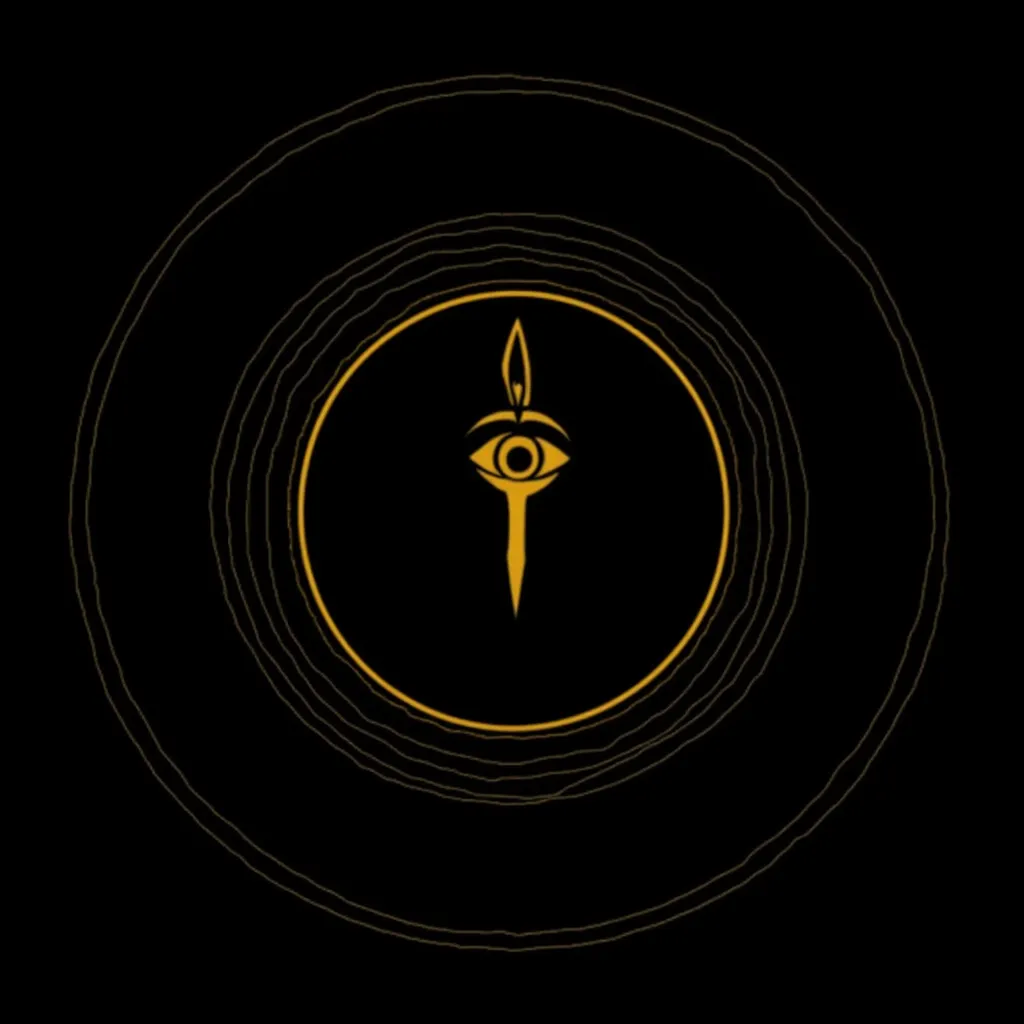

'results/glyphs/snake_20250722_070937.webp'

In [50]:
# Example generations - uncomment and modify as needed

# SUMI model with sumi prompt template (default)
# generate_glyph("dragon", style="sumi", model="sumi")

# MYTHRA model with mythra prompt template
# generate_glyph("phoenix", "fire", "rebirth", style="mythra", model="mythra")

# Mix and match: SUMI model with generic template
# generate_glyph("horse", style="generic", model="sumi")

# MYTHRA model with sumi-style template 
# generate_glyph("wolf", "moon", "wisdom", style="sumi", model="mythra")

# Quick test - generate a snake glyph using SUMI model
generate_glyph("snake", style='mythra', model="mythra")


In [53]:
# Test Dream Glyph (dGlyph)
print("🌙 Testing Dream Glyph (dGlyph):")
simple_svg_glyph("dragon", "fire", "power", glyph_type="dream")

print("\n" + "="*50)
print("✅ SVG generation test complete!")
print("💡 If you see errors above, check your Replicate API access")


🌙 Testing Dream Glyph (dGlyph):
🎨 Generating dream SVG glyph: dragon
📝 Prompt: a DGLYPH fusing dragon with fire and power, symbolic amalgamation, dream synthesis, flowing vector paths
💾 Will save to: results/glyphs/dream/ddragon_fire_power_20250722_071018.svg
❌ Error: ReplicateError Details:
title: Input validation failed
status: 422
detail: - input.style: style must be one of the following: "any", "engraving", "line_art", "line_circuit", "linocut"

💡 Common issues:
   - Check your REPLICATE_API_TOKEN is set correctly
   - Ensure you have access to the recraft-ai/recraft-v3-svg model
   - Try running: os.environ['REPLICATE_API_TOKEN'] = 'your-token-here'

✅ SVG generation test complete!
💡 If you see errors above, check your Replicate API access


In [ ]:
# Generate complete collections - uncomment to run

# Generate generic glyph collection (universal symbols)
# print("🏛️ Generating gGlyph Collection...")
# generic_results = generate_glyph_collection('generic')

# Generate dream glyph collection (amalgamated symbols)  
# print("🌙 Generating dGlyph Collection...")
# dream_results = generate_glyph_collection('dream')

# Custom collection example
# custom_symbols = [
#     ('lotus', 'water', 'enlightenment', 'generic'),
#     ('phoenix', 'fire', 'rebirth', 'dream'),
#     ('spiral', 'air', 'evolution', 'generic')
# ]
# custom_results = generate_glyph_collection('custom', symbols=custom_symbols)

print("💡 Uncomment the lines above to generate complete collections!")


In [ ]:
# Display glyph galleries

# View all glyphs (organized by type)
view_codex('all')

# View specific collections
# view_codex('generic')  # Only gGlyphs
# view_codex('dream')    # Only dGlyphs
